In [1]:
import os
import time
import argparse
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras.layers import Dense, Embedding, Activation, Flatten, Reshape
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D, LSTM, TimeDistributed, MaxPooling2D
from keras.layers import LeakyReLU, Dropout
from keras.layers import BatchNormalization
from keras.layers import Lambda, Input, Dense

from keras.models import Model, Sequential
from keras.losses import mse, binary_crossentropy
from keras.optimizers import Adam, RMSprop
from keras.utils import plot_model

from keras import backend as K


Using TensorFlow backend.


In [2]:
class ElapsedTimer:
    def __init__(self):
        self.start_time = time.time()
    def __elapsed(self,sec):
        if sec < 60:
            return str(sec) + " sec"
        elif sec < (60 * 60):
            return str(sec / 60) + " min"
        else:
            return str(sec / (60 * 60)) + " hr"
    def elapsed_time(self):
        return self.__elapsed(time.time() - self.start_time)

In [3]:
class LaserScans:
    def __init__(self, verbose=False):
        self.verbose = verbose
        self.timesteps = None
        self.cmd_vel = None
        self.scans = None
        self.scan_bound_percentage = 0

    def load(self, datafile, clip_scans_at=None, scan_center_range=None, scan_bound_percentage=None):
        self.clip_scans_at = clip_scans_at
        self.scan_center_range = scan_center_range
        self.scan_bound_percentage = scan_bound_percentage
        self.data = np.loadtxt(datafile).astype('float32')

        self.timesteps = self.data[:, :1]
        self.cmd_vel = self.data[:, 1:7]
        self.scans = self.data[:, 7:]

        if self.verbose:
            print("timesteps --", self.timesteps.shape)
            print("cmd_vel --", self.cmd_vel.shape)
            print("scans --", self.scans.shape, "range [", np.max(self.scans), "-", np.min(self.scans), "]")

        if not self.clip_scans_at is None:
            np.clip(self.scans, a_min=0, a_max=self.clip_scans_at, out=self.scans)

        if not self.scan_center_range is None:
            i_range = 0.5*self.scans.shape[1] - 0.5*self.scan_center_range
            i_range = i_range + 20
            self.scan_bound_percentage = 1.0 - (float(self.scan_center_range)/self.scans.shape[1])
            self.scan_bound_percentage = 0.5*self.scan_bound_percentage
            self.scans = self.scans[:, int(i_range):int(i_range) + self.scan_center_range]
        else:
            if self.scan_bound_percentage != 0:
                min_bound = int(self.scan_bound_percentage*self.scans.shape[1])
                max_bound = int(self.scans.shape[1] - self.scan_bound_percentage*self.scans.shape[1])
                self.scans = self.scans[:, min_bound:max_bound]
                if self.verbose: print("scans bounds (min, max)=", min_bound, max_bound)
        self.scans = self.scans / self.clip_scans_at    # normalization makes the vae work

    def initRand(self, rand_scans_num, scan_dim, clip_scans_at=1.0):
        self.scans = np.random.uniform(0.0, clip_scans_at, size=[rand_scans_num, scan_dim])
        self.cmd_vel = np.zeros((rand_scans_num, 6))
        self.timesteps = np.zeros((rand_scans_num, 1))

    def originalScansDim(self):
        if self.scans is None: return -1
        return self.scans.shape[1]

    def timesteps(self):
        if self.timesteps is None: return np.zeros((1, 1))
        return self.timesteps

    def cmdVel(self):
        if self.cmd_vel is None: return np.zeros((1, 1))
        return self.cmd_vel

    def getScans(self, split_at=0):
        if self.scans is None: return np.zeros((1, 1))
        if split_at == 0: return self.scans

        x_train = self.scans[:int(self.scans.shape[0]*split_at), :]
        x_test = self.scans[int(self.scans.shape[0]*split_at):, :]

        if self.verbose:
            print("scans train:", x_train.shape)
            print("scans test:", x_test.shape)

        return x_train, x_test

    def getScanSegments(self, scan, threshold):
        segments = []
        iseg = 0
        useg = bool(scan[0] > threshold)
        for d in range(scan.shape[0]):
            if useg and scan[d] < threshold:
                segments.append([iseg, d, useg])
                iseg = d
                useg = False
            if not useg and scan[d] > threshold:
                segments.append([iseg, d, useg])
                iseg = d
                useg = True
            if d == scan.shape[0] - 1: segments.append([iseg, d, useg])
        return segments

    def plotScan(self, scan, y=None):
        max_range = 75
        i_range = -int(0.5*max_range)
        theta = (3/2)*np.pi*0.01*np.arange(i_range, i_range + max_range, max_range/self.scan_center_range)
        theta = theta[::-1]

        x_axis = np.arange(scan.shape[0])
        segments = self.getScanSegments(scan, 0.99)
        if self.verbose: print("Segments -- ", np.array(segments).shape, "--", segments)

        plt.figure(figsize=(15, 5))
        plt.subplot(121)
        y_axis = scan
        if not y is None:
            y_axis = y
            plt.plot(x_axis, y_axis, color='lightgray')

        plt.plot(x_axis, scan, color='lightgray')
        for s in segments:
            if s[2]:
                col = '#ff7f0e'
                plt.plot(x_axis[s[0]:s[1]], y_axis[s[0]:s[1]], 'o', markersize=0.5, color=col)
            else:
                col = '#1f77b4'
                plt.plot(x_axis[s[0]:s[1]], scan[s[0]:s[1]], 'o', markersize=0.5, color=col)

        plt.subplot(122, projection='polar')
        plt.plot(theta, scan, color='lightgray')
        for s in segments:
            if s[2]:
                col = '#ff7f0e'
                plt.plot(theta[s[0]:s[1]], y_axis[s[0]:s[1]], 'o', markersize=0.5, color=col)
            else:
                col = '#1f77b4'
                plt.plot(theta[s[0]:s[1]], scan[s[0]:s[1]], 'o', markersize=0.5, color=col)

In [4]:
class VAE:
    def __init__(self, original_dim, batch_size=128, latent_dim=10, intermediate_dim=128, verbose=False):
        self.original_dim = original_dim
        self.batch_size = batch_size
        self.latent_dim = latent_dim
        self.intermediate_dim = intermediate_dim
        self.verbose = verbose
        self.reshape_rows = 32
        self.encoder = None
        self.decoder = None
        self.vae = None
        self.conv_model = False

    def sampling(self, args):
        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        # by default, random_normal has mean=0 and std=1.0
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + K.exp(0.5 * z_log_var) * epsilon

    def buildModel(self):
        if not self.vae is None: return self.vae
        input_shape = (self.original_dim,)
        depth = 32
        dropout = 0.4
        
        e_in = Input(shape=input_shape, name='encoder_input')
        if self.conv_model:
            enc = Reshape((self.reshape_rows, int(self.original_dim/self.reshape_rows), 1,))(e_in)
            enc = Conv2D(depth, 5, strides=2, padding='same')(enc)
            enc = Activation('relu')(enc)
            enc = Dropout(dropout)(enc)
            enc = Conv2D(depth*4, 5, strides=2, padding='same')(enc)
            enc = LeakyReLU(alpha=0.2)(enc)
            enc = Dropout(dropout)(enc)
            # shape info needed to build decoder model
            self.enc_shape = K.int_shape(enc)
            # Out: 1-dim probability
            enc = Flatten()(enc)
        else: enc = e_in
        enc = Dense(self.intermediate_dim, activation='relu')(enc)
        
        self.z_mean = Dense(self.latent_dim, name='z_mean')(enc)
        self.z_log_var = Dense(self.latent_dim, name='z_log_var')(enc)
        z = Lambda(self.sampling, output_shape=(self.latent_dim,), name='z')([self.z_mean, self.z_log_var])
        
        self.encoder = Model(e_in, [self.z_mean, self.z_log_var, z], name='encoder')
        if self.verbose: self.encoder.summary()
        
        depth = 2
        
        d_in = Input(shape=(self.latent_dim,), name='z_sampling')
        if self.conv_model:
            dec = Dense(self.enc_shape[1]*self.enc_shape[2]*self.enc_shape[3], activation='relu')(d_in)
            dec = Reshape((self.enc_shape[1], self.enc_shape[2], self.enc_shape[3]))(dec)

            dec = Conv2DTranspose(filters=depth*8, kernel_size=5,
                              activation='relu', strides=2, padding='same')(dec)
            dec = Conv2DTranspose(filters=depth*4, kernel_size=5,
                              activation='relu', strides=2, padding='same')(dec)
            dec = Dropout(dropout)(dec)
            dec = Dense(depth, activation='sigmoid')(dec)
            dec = Flatten()(dec)
        else:
            dec = Dense(self.intermediate_dim, activation='sigmoid')(d_in)
            
        d_out = Dense(self.original_dim, activation='relu')(dec)

        # instantiate decoder model
        self.decoder = Model(d_in, d_out, name='decoder')
        if self.verbose: self.decoder.summary()
        
        vae_out = self.decoder(self.encoder(e_in)[2])
        self.vae = Model(e_in, vae_out, name='vae_mlp')
        
        reconstruction_loss = binary_crossentropy(e_in, vae_out)
        reconstruction_loss *= self.original_dim
        
        kl_loss = 1 + self.z_log_var - K.square(self.z_mean) - K.exp(self.z_log_var)
        kl_loss = K.sum(kl_loss, axis=-1)
        kl_loss *= -0.5
        vae_loss = K.mean(reconstruction_loss + kl_loss)

        self.vae.add_loss(vae_loss)
        self.vae.compile(optimizer=Adam(lr=0.0001))
        if self.verbose: self.VAE.summary()
        return self.vae

    def fitModel(self, x, x_test=None, epochs=10, verbose=None):
        if x_test is None:
            self.vae.fit(x, epochs=epochs, batch_size=self.batch_size, verbose=verbose)
        else:
            self.vae.fit(x, epochs=epochs, batch_size=self.batch_size, verbose=verbose,
                         validation_data=(x_test, None))

    def encode(self, x, batch_size=None):
        if len(x.shape) == 1: x = np.array([x])
        z_mean, z_var_log, z = self.encoder.predict(x, batch_size=batch_size)
        return z_mean

    def decode(self, z_mean):
        return self.decoder.predict(z_mean)

In [5]:
class AE:
    def __init__(self, original_dim, batch_size=128, latent_dim=10, verbose=False):
        self.original_dim = original_dim
        self.batch_size = batch_size
        self.latent_dim = latent_dim
        self.verbose = verbose
        self.reshape_rows = 32
        self.encoder = None
        self.decoder = None
        self.ae = None
        
    def buildModel(self):
        if not self.ae is None: return self.ae
        input_shape = (self.original_dim,)
        depth = 265
        dropout = 0.4
        
        #### ENCODER
        e_in = Input(shape=input_shape, name='encoder_input')
        enc=e_in
        # enc = Reshape((self.reshape_rows, int(self.original_dim/self.reshape_rows), 1,))(e_in)
        # enc = Conv2D(depth, 5, strides=2, activation='relu', padding='same')(enc)
        # enc = Conv2D(int(depth/2), 5, strides=2, activation='relu', padding='same')(enc)
        # enc = Conv2D(int(depth/4), 5, strides=2, activation='relu', padding='same')(enc)
        # enc = Dropout(dropout)(enc)
        # self.enc_shape = K.int_shape(enc)  # shape info needed to build decoder model
        # enc = Flatten()(enc)
        enc = Dense(depth, activation='relu')(enc)
        e_out = Dense(self.latent_dim, activation='relu')(enc)
        
        self.encoder = Model(e_in, e_out, name='encoder')
        if self.verbose: self.encoder.summary()
        
        #### DECODER
        d_in = Input(shape=(self.latent_dim,), name='decoder_input')
        dec=d_in
        # dec = Dense(self.enc_shape[1]*self.enc_shape[2]*self.enc_shape[3], activation='relu')(d_in)
        # dec = Reshape((self.enc_shape[1], self.enc_shape[2], self.enc_shape[3]))(dec)
        # dec = Conv2DTranspose(filters=depth, kernel_size=5, activation='relu', strides=2, padding='same')(dec)
        # dec = Conv2DTranspose(filters=int(depth/2), kernel_size=5, activation='relu', strides=2, padding='same')(dec)
        # dec = Dropout(dropout)(dec)
        dec = Dense(int(depth/32), activation='sigmoid')(dec)
        # dec = Flatten()(dec)
        d_out = Dense(self.original_dim, activation='relu')(dec)

        self.decoder = Model(d_in, d_out, name='decoder')
        if self.verbose: self.decoder.summary()
        
        #### AUTOENCODER
        vae_out = self.decoder(self.encoder(e_in))
        self.ae = Model(e_in, vae_out, name='autoencoder')
        self.ae.compile(optimizer='adadelta', loss='binary_crossentropy')
        if self.verbose: self.ae.summary()
        return self.ae
    
    def fitModel(self, x, x_test=None, epochs=10, verbose=None):
        if x_test is None:
            for e in range(epochs):
                for i in range(0, x.shape[0] - self.batch_size, self.batch_size):
                    self.ae.train_on_batch(x[i:i + self.batch_size], x[i:i + self.batch_size]) 
        else:
            self.ae.fit(x, epochs=epochs, batch_size=self.batch_size,
                        verbose=verbose, validation_data=(x_test, None))
            
    def encode(self, x, batch_size=None):
        if len(x.shape) == 1: x = np.array([x])
        return self.encoder.predict(x, batch_size=batch_size)
        
    def decode(self, latent):
        return self.decoder.predict(latent)

In [6]:
if __name__ == "__main__":
    # DIAG_first_floor.txt
    # diag_labrococo.txt
    # diag_underground.txt
    ls = LaserScans(verbose=True)
    ls.load("../../dataset/diag_underground.txt", clip_scans_at=8, scan_center_range=512)

timesteps -- (13545, 1)
cmd_vel -- (13545, 6)
scans -- (13545, 721) range [ 30.0 - 0.0 ]


In [7]:
    ae = VAE(ls.originalScansDim(), batch_size=128, latent_dim=10, verbose=False)

In [8]:
    ae.buildModel()
    
    x, x_test = ls.getScans(0.9)
    ae.fitModel(x, x_test=None, epochs=50, verbose=0)
    print('done')

scans train: (12190, 512)
scans test: (1355, 512)
done


Segments --  (3, 3) -- [[0, 154, False], [154, 224, True], [224, 511, False]]


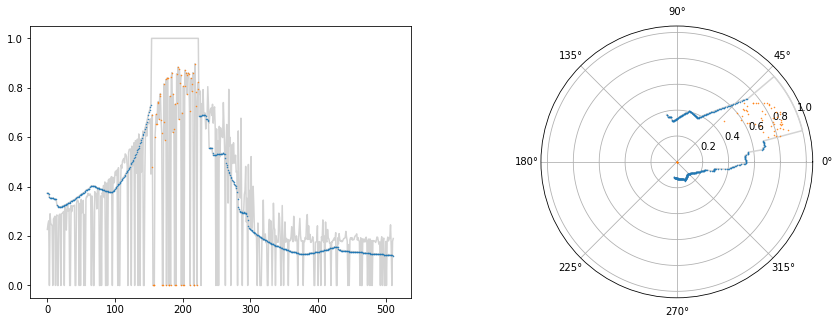

In [9]:
    batch_sz = 8
    gan_batch_sz = 8
    scan_idx = 1000

    to_show_idx = 10
    
    scan = x[scan_idx:(scan_idx + batch_sz*gan_batch_sz)]
    latent = ae.encode(scan)
    
    # plt.plot(latent[to_show_idx])
    dscan = ae.decode(latent)
    
    ls.plotScan(scan[to_show_idx], dscan[to_show_idx])